<a href="https://colab.research.google.com/github/Infinity-ops/CIFAR-10_Multi-Label/blob/main/New_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Keras imports for the convolutional neural network
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate,  Input
from keras import backend as K
from keras import losses
from tensorflow.keras import optimizers
from keras import callbacks
from keras.initializers import RandomNormal

# Additional packages
from PIL import Image
import glob
import os
import numpy as np
from sklearn import utils 
from sklearn.model_selection import KFold
import IPython.display as dp
import matplotlib.pyplot as plt
%matplotlib inline

# plt.rcParams['figure.figsize'] = (18, 6)
from scipy.stats import itemfreq
from math import floor, ceil
import random

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape,y_train.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)


In [ ]:
#normalize data
if X_train.max() >1:
    X_train = X_train / 255
    X_test = X_test / 255

default_shape = X_train.shape
#reshape input data to 1 channel
X_train = X_train.reshape(-1,default_shape[1],default_shape[2],1)
X_test = X_test.reshape(-1,default_shape[1],default_shape[2],1)
image_dim = X_train.shape[1:]


In [ ]:
image_dim

(28, 28, 1)

In [ ]:
image_dim = X_train.shape[1:]
encoder = Sequential()
encoder.add(Conv2D(32,kernel_size=(3,3), strides=(1,1),padding='same', activation='relu',input_shape=image_dim))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same',activation='relu'))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same',activation='relu'))
encoder.add(Flatten())
encoder.add(Dense(100,activation='sigmoid'))
encoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [ ]:
encoder_out_dim = encoder.layers[-1].output_shape[1:]
decoder = Sequential()
decoder.add(Dense(6272, activation='sigmoid', input_shape=encoder_out_dim))
decoder.add(Reshape(( 7, 7, 128)))
decoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same', activation='relu'))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same', activation='relu'))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(1,kernel_size=(3,3), strides=(1,1),padding='same', activation='sigmoid'))
decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_3 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                  

In [ ]:
enc_dec = Sequential([encoder,decoder])
enc_dec.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 100)               719972    
                                                                 
 sequential_4 (Sequential)   (None, 28, 28, 1)         855425    
                                                                 
Total params: 1,575,397
Trainable params: 1,575,397
Non-trainable params: 0
_________________________________________________________________


In [ ]:
enc_dec.compile(optimizer='nadam', loss = 'binary_crossentropy')
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, restore_best_weights=True)
history = enc_dec.fit(X_train,X_train, batch_size=100,epochs=1000,validation_split=0.2, verbose=2,callbacks=[es,es])

Epoch 1/1000
480/480 - 17s - loss: 0.2685 - val_loss: 0.2622 - 17s/epoch - 36ms/step
Epoch 2/1000
480/480 - 15s - loss: 0.2634 - val_loss: 0.2628 - 15s/epoch - 31ms/step
Epoch 3/1000
480/480 - 15s - loss: 0.2634 - val_loss: 0.2624 - 15s/epoch - 31ms/step
Epoch 4/1000
480/480 - 15s - loss: 0.2634 - val_loss: 0.2622 - 15s/epoch - 32ms/step
Epoch 5/1000
480/480 - 15s - loss: 0.2634 - val_loss: 0.2623 - 15s/epoch - 32ms/step
Epoch 6/1000
Restoring model weights from the end of the best epoch: 1.
Restoring model weights from the end of the best epoch: 1.
480/480 - 15s - loss: 0.2633 - val_loss: 0.2627 - 15s/epoch - 32ms/step
Epoch 6: early stopping
Epoch 6: early stopping


In [ ]:
enc_dec.evaluate(X_test,X_test,batch_size=1000)

10/10 [==============================] - 2s 64ms/step - loss: 0.2626


0.26264050602912903

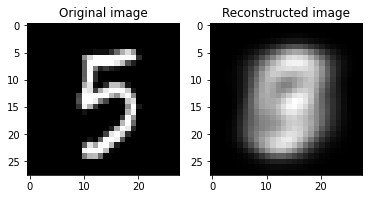

In [ ]:
random_label = np.random.randint(0,9999)
img_sample = X_test[random_label,:,:].reshape((1,28,28,1))
plt.subplot(1,2,1)
plt.imshow(img_sample.reshape(28,28), cmap='gray');
plt.title('Original image');
pred_img = enc_dec.predict(img_sample) 
plt.subplot(1,2,2)
plt.imshow(pred_img.reshape(28,28), cmap='gray');
plt.title('Reconstructed image');

In [ ]:
# autoencoder for decoder structure
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras import optimizers


encoding_dim = Input(shape=(1,))
input_img = Input(shape=(784,))

decoded_1 = Dense(128, activation='relu')(encoding_dim)
decoded_2 = Dense(256, activation='relu')(decoded_1)
decoded = Dense(784, activation='sigmoid')(decoded_2)
print(decoded.shape)
autoencoder = Model(encoding_dim, decoded)

myoptimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)
autoencoder.compile(optimizer=myoptimizer, loss='binary_crossentropy')
autoencoder.summary()
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr = x_tr.astype('float32') / 255.
x_te = x_te.astype('float32') / 255.
x_tr = x_tr.reshape((len(x_tr), np.prod(x_tr.shape[1:])))
x_te = x_te.reshape((len(x_te), np.prod(x_te.shape[1:])))

autoencoder.fit(y_tr, x_tr,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(y_te, x_te))

(None, 784)
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_71 (Dense)            (None, 128)               256       
                                                                 
 dense_72 (Dense)            (None, 256)               33024     
                                                                 
 dense_73 (Dense)            (None, 784)               201488    
                                                                 
Total params: 234,768
Trainable params: 234,768
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
235/235 [==============================] - 4s 11ms/step - loss: 0.3022 - val_loss: 0.2552
Epoch 2/100
235/235 [==============================] - 2s 8ms/step - loss: 0.2494 - val_loss: 0.2444
Epoch 3/100
235/235 [==============================] - 1s 6ms/step - loss: 0.2433 - val_loss: 0.2406
Epoch 4/100
235/235 [==============================] - 1s 6ms/step - loss: 0.2404 - val_loss: 0.2379
Epoch 5/100
235/235 [==============================] - 1s 6ms/step - loss: 0.2377 - val_loss: 0.2351
Epoch 6/100
235/235 [==============================] - 1s 6ms/step - loss: 0.2352 - val_loss: 0.2332
Epoch 7/100
235/235 [==============================] - 1s 5ms/step - loss: 0.2334 - val_loss: 0.2316
Epoch 8/100
235/235 [==============================] - 1s 5ms/step - loss: 0.2323 - val_loss: 0.2306
Epoch 9/100
235/235 [==============================] - 1s 5ms/step - loss: 0.2316 - val_loss: 0.2300
Epoch 10/100
235/235 [==============================] - 1s 5ms/step - loss: 0.2312 - val_l

In [ ]:
encoder.save('encoder')
autoencoder.save('autoencoder')

# duplicate encoders and freeze weights
encoder1 = keras.models.load_model('encoder') 
encoder1._name = 'encoder1'
encoder1.trainable = False

encoder2 = keras.models.load_model('encoder')
encoder2._name = 'encoder2'
encoder2.trainable = False

autoencoder = keras.models.load_model('autoencoder')
autoencoder._name = 'autoencoder'
autoencoder.trainable = False



In [ ]:
import tensorflow
# create model to learn it all
input1 = Input(shape=image_dim)
input2 = Input(shape=image_dim)
enc1_out = encoder1(input1)
enc2_out = encoder2(input2)
model_c = Concatenate()([enc1_out,enc2_out])
model_c = Dense(1000,activation='relu')(model_c)
model_b1 = Dense(200,activation='relu')(model_c)
model_b2 = Dense(200,activation='relu')(model_c)
model_b3 = Dense(200,activation='relu')(model_c)
model_b4 = Dense(200,activation='relu')(model_c)
model_b5 = Dense(200,activation='relu')(model_c)

units_add =  Dense(10,activation='softmax',name ='units_add')(model_b1)
print((units_add.shape))

tens_add = Dense(1,activation='sigmoid',name ='tens_add')(model_b2)

dec2_out = autoencoder(tens_add)
dec2_out = tensorflow.reshape(dec2_out, [28,28,1])
dec1_out = autoencoder(K.argmax(units_add[0:], axis=-1))
dec1_out = tensorflow.reshape(dec1_out,[28,28,1])
print(dec1_out.shape)
model_complete = Model(inputs=[input1,input2],outputs=[dec1_out, dec2_out])
model_complete.compile(optimizer='nadam', loss = ['binary_crossentropy','binary_crossentropy'], metrics=['acc'])
model_complete.summary()

(None, 10)
(28, 28, 1)
Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_97 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_98 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder1 (Sequential)          (None, 100)          719972      ['input_97[0][0]']               
                                                                                                  
 encoder2 (Sequential)          (None, 100)          719972      ['input_98[0][0]']               
                                                                    

In [ ]:
(X_train_keras, y_train_keras), (X_test_keras, y_test_keras) = mnist.load_data()

#Dataset for additions
# Generate the 100 unique pairs
unique_pairs = [str(x)+str(y) for x in range(10) for y in range(10)]
#print(unique_pairs)
# Create 10 test set pairs
test_set_pairs = []

while(len(test_set_pairs) < 10):
    pair_to_add = random.choice(unique_pairs)
    if pair_to_add not in test_set_pairs:
        test_set_pairs.append(pair_to_add)

#Use the remaining 90 as training set pairs
train_set_pairs = list(set(unique_pairs) - set(test_set_pairs))


# Ensure there are 90 training set pairs and 10 test set pairs
assert(len(test_set_pairs) == 10)
assert(len(train_set_pairs) == 90)

# Ensure no test set pairs appear in the training set pairs:
for test_set in test_set_pairs:
    assert(test_set not in train_set_pairs)
    #print("%s not in training set." % test_set)
    
from keras import backend as K
import math
y = 30

def num2img(num):
    first_digit = floor(num/10)
    last_digit = num%10
    y = np.zeros((28,56), dtype="uint8")
    first = find_n_array(first_digit)
    sec = find_n_array(last_digit)
    # Populate the empty matrix with data from two image matrices from the training set
    y[:,:28] = X_train_keras[first]
    y[:,28:] = X_train_keras[sec]
    return y


def find_n_array(num):
    for i in range(0, len(y_train_keras)):
        if num == y_train_keras[i]:
            index = i
            break
    return index 

#Image.fromarray(num2img(18))
X_train_1 = []
X_train_2 = []
y_train_1 = []
y_train_2 = []

# Number of samples per permutation (e.g. there are 90 permutations in the train set so 1000 * 90)
samples_per_permutation = 10  # Set to 10 for brevity. Results in the paper were for 1,000 samples.

for train_set_pair in train_set_pairs:
    for _ in range(samples_per_permutation):
        rand_i = np.random.choice(np.where(y_train_keras == int(train_set_pair[0]))[0])
        rand_j = np.random.choice(np.where(y_train_keras == int(train_set_pair[1]))[0])
        X_train_1.append(X_train_keras[rand_i])
        X_train_2.append(X_train_keras[rand_j])
        y_train_1.append((num2img(y_train_keras[rand_i] + y_train_keras[rand_j]))[:,:28])
        y_train_2.append((num2img(y_train_keras[rand_i] + y_train_keras[rand_j]))[:,28:])        

        
X_test_1 = []
X_test_2 = []
y_test_1 = []
y_test_2 = []

for test_set_pair in test_set_pairs:
    for _ in range(samples_per_permutation):
        rand_i = np.random.choice(np.where(y_test_keras == int(test_set_pair[0]))[0])
        rand_j = np.random.choice(np.where(y_test_keras == int(test_set_pair[1]))[0])
        X_test_1.append(X_test_keras[rand_i])
        X_test_2.append(X_test_keras[rand_j])
        y_test_1.append((num2img(y_test_keras[rand_i] + y_test_keras[rand_j]))[:,:28])
        y_test_2.append((num2img(y_test_keras[rand_i] + y_test_keras[rand_j]))[:,28:])
        
#print("Training set size: %s, test set size: %s" % (len(X_train), len(X_test)))

# The training set should be 90,000 images in size (90 permutations * 1000)
# and the label data, y_train, must also be equal in length.
assert(len(X_train_1) == samples_per_permutation * 90)
assert(len(X_train_1) == len(y_train_1))
assert(len(X_train_2) == samples_per_permutation * 90)
assert(len(X_train_2) == len(y_train_2))

# The test set should be 10,000 images in size (10 permutations * 1000)
# and the label data, y_test, must also be equal in length
assert(len(X_test_1) == samples_per_permutation * 10)
assert(len(X_test_1) == len(y_test_1))
assert(len(X_test_2) == samples_per_permutation * 10)
assert(len(X_test_2) == len(y_test_2))

# Ensure we are using NumPy arrays
X_train_1 = np.asarray(X_train_1)
y_train_1 = np.asarray(y_train_1)
X_test_1 = np.asarray(X_test_1)
y_test_1 = np.asarray(y_test_1)

X_train_2 = np.asarray(X_train_2)
y_train_2 = np.asarray(y_train_2)
X_test_2 = np.asarray(X_test_2)
y_test_2 = np.asarray(y_test_2)

# Reshape the data sets to a format suitable for Keras
X_train_1 = X_train_1.reshape(X_train_1.shape[0], X_train_1.shape[1], X_train_1.shape[2], 1)
X_test_1 = X_test_1.reshape(X_test_1.shape[0], X_test_1.shape[1], X_test_1.shape[2], 1)
y_train_1 = y_train_1.reshape(y_train_1.shape[0], y_train_1.shape[1], y_train_1.shape[2], 1)
y_test_1 = y_test_1.reshape(y_test_1.shape[0], y_test_1.shape[1], y_test_1.shape[2], 1)

X_train_2 = X_train_2.reshape(X_train_2.shape[0], X_train_2.shape[1], X_train_2.shape[2], 1)
X_test_2 = X_test_2.reshape(X_test_2.shape[0], X_test_2.shape[1], X_test_2.shape[2], 1)
y_train_2 = y_train_2.reshape(y_train_2.shape[0], y_train_2.shape[1], y_train_2.shape[2], 1)
y_test_2 = y_test_2.reshape(y_test_2.shape[0], y_test_2.shape[1], y_test_2.shape[2], 1)

# Reformat the images to use floating point values rather than integers between 0-255
X_train_1 = X_train_1.astype('float32')
X_test_1 = X_test_1.astype('float32')
X_train_1 /= 255
X_test_1 /= 255
X_train_2 = X_train_2.astype('float32')
X_test_2 = X_test_2.astype('float32')
X_train_2 /= 255
X_test_2 /= 255

y_train_1 = y_train_1.astype('float32')
y_test_1 = y_test_1.astype('float32')
y_train_1 /= 255
y_test_1 /= 255
y_train_2 = y_train_2.astype('float32')
y_test_2 = y_test_2.astype('float32')
y_train_2 /= 255
y_test_2 /= 255



In [ ]:
units_add[0]

<KerasTensor: shape=(10,) dtype=float32 (created by layer 'tf.__operators__.getitem_3')>

In [ ]:
history = model_complete.fit([X_train_1,X_train_2],[y_train_1, y_train_2], batch_size=100,epochs=1000,validation_split=0.2, verbose=1,callbacks=[es,es])

Epoch 1/1000


InvalidArgumentError: ignored

In [ ]:
for _ in range(10):
    ind = random.randint(0, len(X_test_1)-1)
    print(ind)
    image_predicted_1 = X_test_1[ind].copy()
    image_predicted_1 = image_predicted_1.reshape((28, 28))
    image_predicted_1 = image_predicted_1 * 255
    image_predicted_1 = image_predicted_1.astype('uint8')
    dp.display_png(Image.fromarray(image_predicted_1))
    image_predicted_2 = X_test_2[ind].copy()
    image_predicted_2 = image_predicted_2.reshape((28, 28))
    image_predicted_2 = image_predicted_2 * 255
    image_predicted_2 = image_predicted_2.astype('uint8')
    dp.display_png(Image.fromarray(image_predicted_2))
    p,q = model_complete.predict([X_test_1[ind].reshape(1, 28, 28, 1), X_test_2[ind].reshape(1, 28, 28, 1)] )
    image_resulted = q
    image_resulted = image_resulted.reshape((28, 28))
    image_resulted = image_resulted * 255
    image_resulted = image_resulted.astype('uint8')
    dp.display_png(Image.fromarray(image_resulted))

    #print("Prediction for %s: %s" % (y_test[ind], p))

27


1


77


30


91


79


41


5


17


23
